## Low-level benchmarks

The "low-level" benchmarks correspond to circuits composed of only one type of gate, with various "depths" (i.e. numbers of nested gates).   
For example, ```circuit-ADD-3.sheep``` contains three nested "ADD" gates: ```output=((a+b)+c)+d```.

The first part of this notebook runs scripts to perform various systematic scans of the parameter space (this may take some time).

The second part of the notebook demonstrates how to query the database of benchmark results, and produces tables and plots.  

The code in this notebook should be run from the base SHEEP directory.
Dependencies are:
* pandas
* numpy
* matplotlib
* sqlalchemy

In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Running the benchmark scans

In [4]:
import os
import sys
sys.path.append(os.environ["SHEEP_HOME"])
from pysheep.low_level_benchmarks import *

In [6]:
run_all(["ADD"],["int8_t"],["HElib_F2"])


NameError: name 'get_bitwidth' is not defined

## Tabulating and plotting the results

Import some SQLAlchemy utilities from the SHEEP frontend code.

In [3]:
from pysheep.common.database import BenchmarkMeasurement, session, build_filter

ImportError: No module named 'pysheep.common'

Read all the rows from the database and put them into a pandas dataframe

In [3]:
all_rows = pd.read_sql(session.query(BenchmarkMeasurement).statement,session.bind)
all_rows["Levels"] = all_rows["HElib_Levels"] - 2.
all_rows.loc[all_rows["Levels"].isnull(), "Levels"] = all_rows.loc[all_rows["Levels"].isnull(), "SEAL_N"]/2048.
all_rows[["context_name","gate_name","Levels","depth","input_bitwidth","input_signed","is_correct"]].head()


,context_name,gate_name,Levels,depth,input_bitwidth,input_signed,is_correct
0,HElib_Fp,None,5,None,8,True,True
1,HElib_Fp,None,6,None,16,True,False
2,HElib_Fp,None,6,None,16,True,False
3,HElib_Fp,None,5,None,8,True,True
4,HElib_Fp,None,6,None,16,True,False


### Scan 1:  
For a single gate, set the "leveled" libraries (HElib_Fp and SEAL) to support multiplicative levels of 1,4,8 and look at the execution time for 8-bit signed integers:

In [71]:
def libs_op_levels(op_str,bitwidth, is_signed, libs_list):
    rows = all_rows[(all_rows.input_bitwidth==bitwidth) & ((all_rows.Levels == 1)| (all_rows.Levels == 4)|(all_rows.Levels == 8)) & (all_rows.gate_name==op_str) & all_rows.context_name.isin(libs_list) & (all_rows.input_signed==is_signed)]
    rows.context_name.name = "Library"
    rows.execution_time.name = "Time (s)" 
    return rows.drop_duplicates(["context_name", "Levels"]).pivot(
        index='context_name', columns='Levels', values='execution_time'
    )

In [74]:
rows=libs_op_levels("NEGATE",8,True,["SEAL"])
rows

Levels,1.0,4.0,8.0
context_name,,,
SEAL,0.00007,0.00077,0.00319


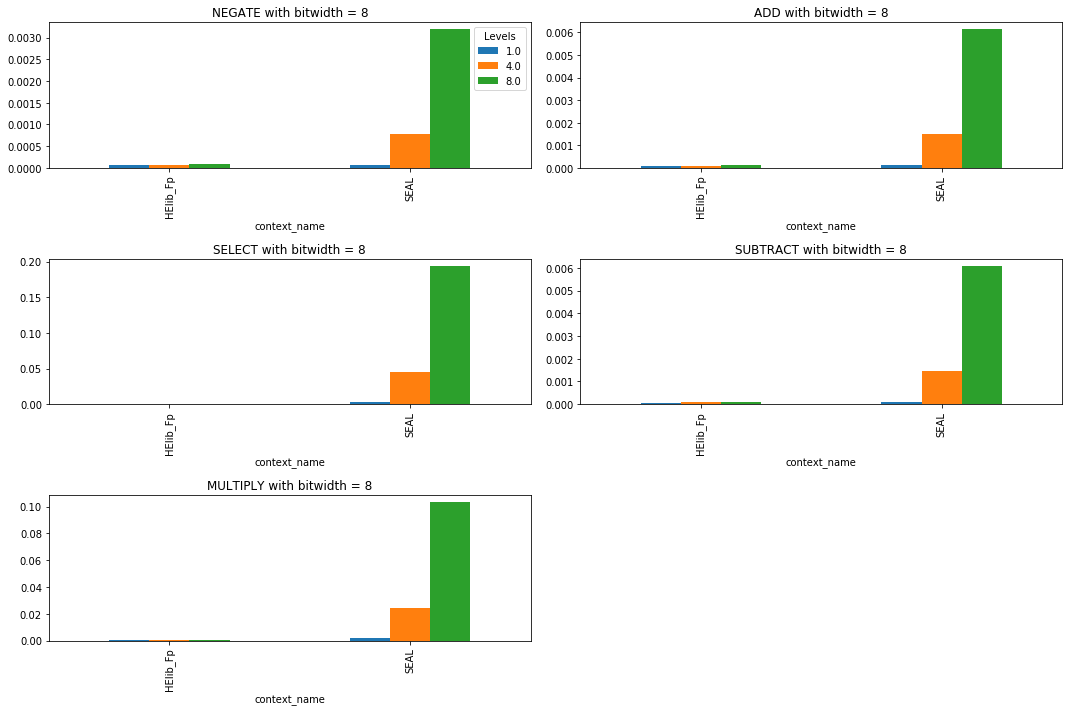

In [76]:
all_ops = set(all_rows.gate_name)
bitwidth = 8
is_signed = True
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_Fp", "SEAL"]
    rows = libs_op_levels(op, bitwidth, is_signed, libs)
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
#     axis.set_yscale("log")
    rows.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

### Scan 2: 
Set parameters for the "leveled" libraries (HElib_Fp and SEAL) to be able to support multiplicative depth of 4, then see how many of each operation we can do and still get the correct results.

In [106]:
def libs_op_depth_level4(op_str, bitwidth, is_signed, libs_list):
    rows = all_rows[(all_rows.is_correct==True) & (all_rows.Levels==4) & (all_rows.input_bitwidth==bitwidth) & (all_rows.gate_name==op_str) & all_rows.context_name.isin(libs_list) & (all_rows.input_signed==is_signed)]
    rows.context_name.name = "Library"
    rows.execution_time.name = "Time (s)" 
    return rows.drop_duplicates(["context_name", "depth"]).pivot(index='context_name', columns='depth', values='execution_time')
all_ops = set(all_rows.gate_name)

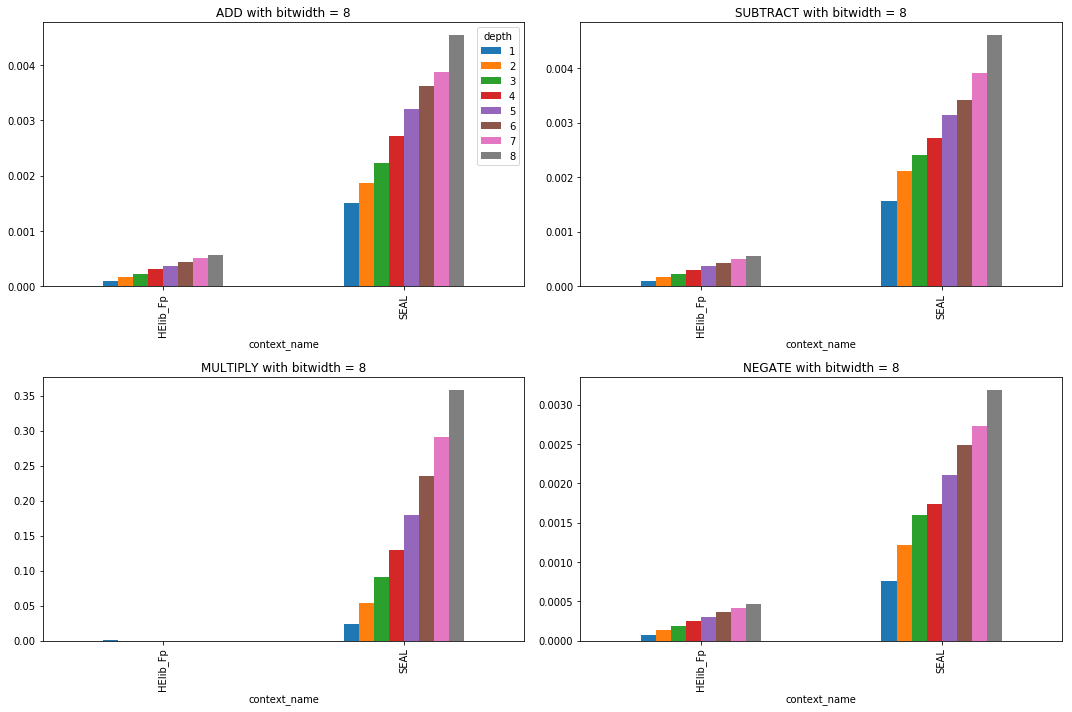

In [108]:

all_ops = ["ADD","SUBTRACT","MULTIPLY","NEGATE"]
bitwidth = 8
is_signed = False
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_Fp", "SEAL"]
    rows = libs_op_depth_level4(op, bitwidth, is_signed, libs)
    
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    #axis.set_yscale("log")
    rows.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

### Scan 3:
chain $d$ gates together, with the leveled libraries set to the appropriate parameters to support that depth.


HElib_F2 and TFHE both deal with binary arrays, and by default bootstrap for every operation:

In [ ]:
def libs_op_depth(op_str, bitwidth, is_signed, libs_list):
    rows = all_rows[(all_rows.input_bitwidth==bitwidth) & (all_rows.gate_name==op_str) & all_rows.context_name.isin(libs_list) & (all_rows.input_signed==is_signed)]
    rows.context_name.name = "Library"
    rows.execution_time.name = "Time (s)" 
    return rows.drop_duplicates(["context_name", "depth"]).pivot(index='context_name', columns='depth', values='execution_time')

{'NEGATE', 'ADD', 'SELECT', 'SUBTRACT', 'MULTIPLY'}


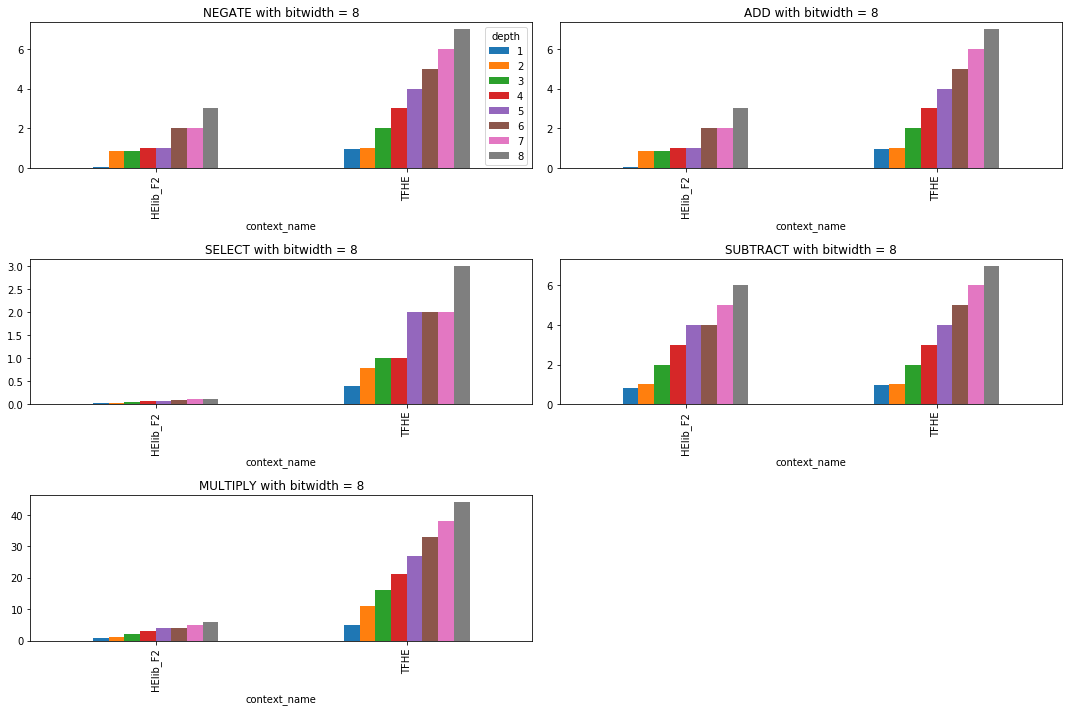

In [112]:
all_ops = set(all_rows.gate_name)
bitwidth = 8
is_signed = False
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_F2", "TFHE"]# all_libs
    rows = libs_op_depth(op, bitwidth, is_signed, libs)
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    #axis.set_yscale("log")
    rows.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

Now we do the same for the two libraries that operate on integers - SEAL and HElib_Fp

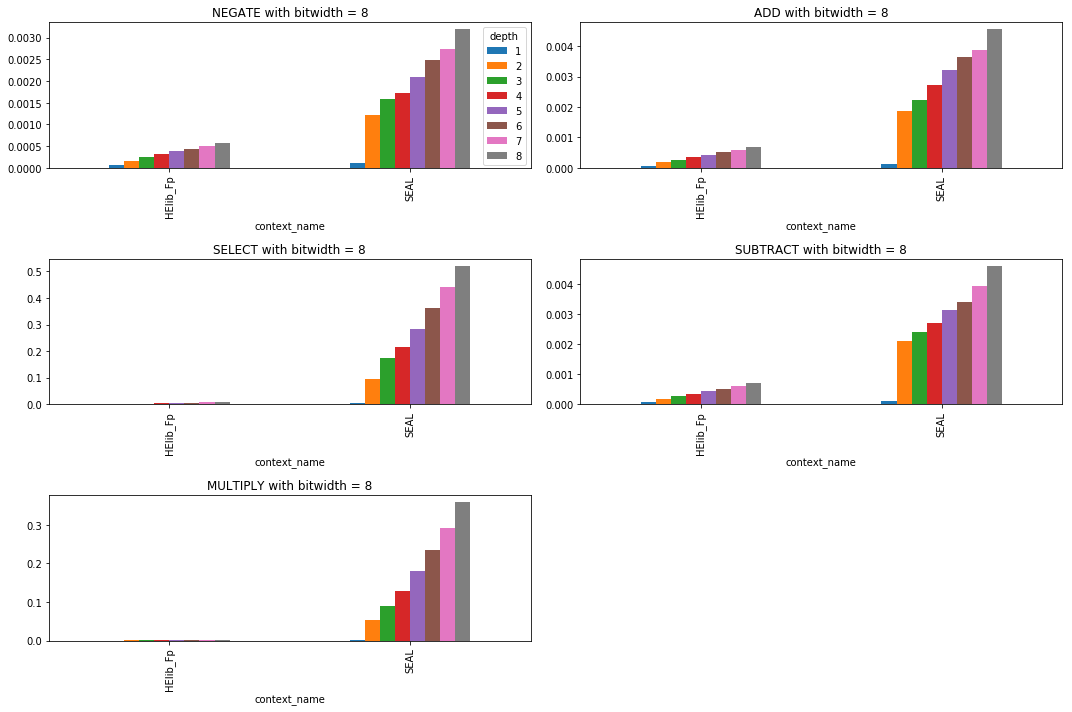

In [113]:
all_ops = set(all_rows.gate_name)
bitwidth = 8
is_signed = False
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_Fp", "SEAL"]# all_libs
    rows = libs_op_depth(op, bitwidth, is_signed, libs)
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    #axis.set_yscale("log")
    rows.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

### Scan 4: 
Look at how the number of bits in the input type affects the execution time for a single gate of each operation.

In [130]:
def ops_lib_bitwidth(depth, is_signed, lib, ops):
    rows = all_rows[ (all_rows.context_name==lib)&(all_rows.input_signed==is_signed)&(all_rows.depth==depth)&(all_rows.gate_name.isin(ops))]
    rows.execution_time.name = "Time (s)" 
    rows.gate_name.name = "Operation"
    return rows.drop_duplicates(["gate_name", "input_bitwidth"]).pivot(index='gate_name', columns='input_bitwidth', values='execution_time')

In [131]:
rows = ops_lib_bitwidth(1,False,"TFHE",["ADD"])
rows

input_bitwidth,1,8,16,32
gate_name,,,,
ADD,0.02549,0.95828,1.0,4.0


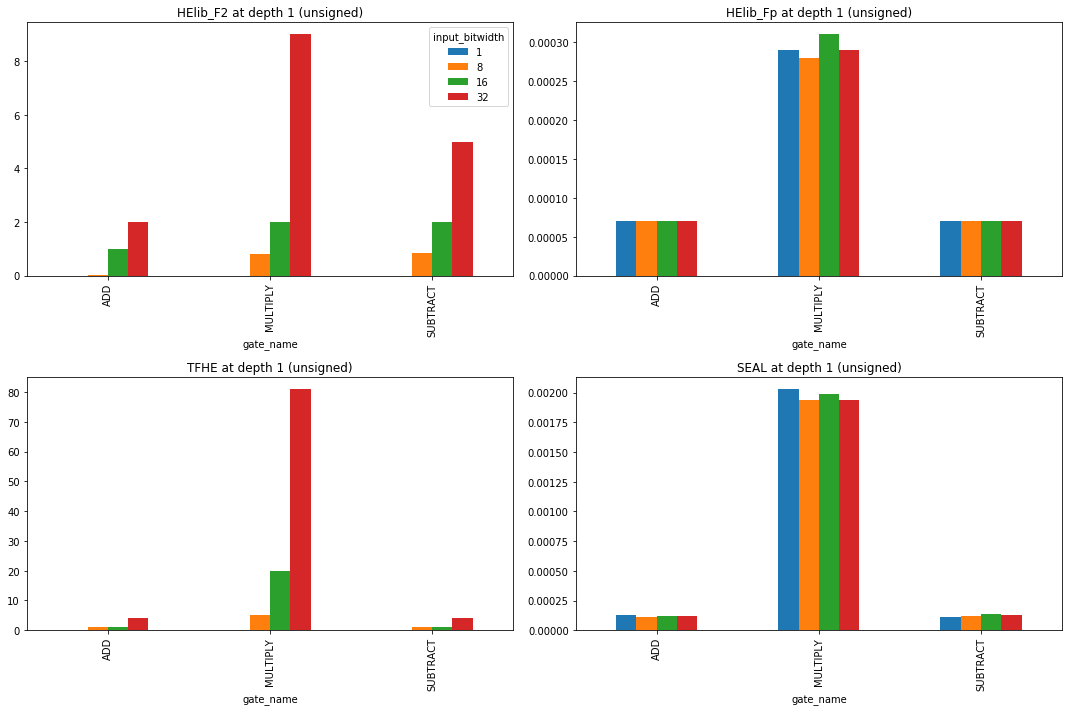

In [132]:
all_ops = set(all_rows.gate_name)
ops = all_ops#["ADD", "SUBTRACT"]
ops = ["ADD","SUBTRACT","MULTIPLY"]
all_libs = ["HElib_F2", "HElib_Fp", "TFHE", "SEAL"]
depth = 1
is_signed = False
for i, lib in enumerate(all_libs):
    rows = ops_lib_bitwidth(depth, False, lib, ops)
    axis = plt.subplot((len(all_libs) + 2 // 2) // 2, 2, i + 1)
    #axis.set_yscale("log")
    rows.plot(ax=axis, title='{} at depth {} ({}signed)'.format(lib, depth, '' if is_signed else 'un'), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()